In [ ]:
#==========================================================================================
# text추출원본파일을 가지고 임베딩, 유사문서 만들고, MRR 및 검색률 계산하는 예시임.
# => text추출원본파일은 doc_extrac.ipynb 코드를 이용해서 만들면 됨. 반드시 파일명 앞에 '숫자(고유번호)_' 를 붙여야함
# => 임베딩 방식, 유사문서만드는방식, 모델설정등은 './data/test_settings.yaml' 파일을 변경하면됨.
#
# [임베딩]  
# => 1. text추출원본파일폴더 목록 얻기 -> 3.임베딩 환경 설정 -> 4.문서 임베딩
#
# [유사문서 제작]
# => 1. text추출원본파일폴더 목록 얻기 -> 2.유사 문서 파일 만들기
#
# [MRR 및 검색률 계산]
# => 1. text추출원본파일폴더 목록 얻기 -> 3.임베딩 환경 설정 -> 5.검색 -> 6.MRR 계산
#==========================================================================================

In [1]:
#------------------------------------------------------------------------------------------
# 1. text추출원본파일폴더 목록 얻기
# => 임베딩할 text추출원본파일폴더에서 파일풀경로를 얻어와서 리스트로 저장해 둠.
# => 반드시 text추출원본파일명은 유니크해야함.(*중복되면 안됨)
#------------------------------------------------------------------------------------------
import os
import time
import numpy as np
import sys
import json
from tqdm import tqdm 
import numpy as np
import pandas as pd

from embedding import embedding_pdf
from utils import MyUtils
from utils import weighted_reciprocal_rank_fusion, clustering_embedding

myutils = MyUtils(yam_file_path='./data/test_settings.yaml')

# 임베딩할 원본폴더에서 파일풀경로를 리스트로 저장해 둠.
file_folder = "../../data11/docs/"
files:list = []
len_list = []

file_paths = myutils.getListOfFiles(file_folder) # 폴더에 파일 path 얻어옴.

for idx, file_path in enumerate(file_paths):
    if '.ipynb_checkpoints' not in file_path:
        
        try:
            # src 파일을 읽어온다.
            with open(file_path, 'r', encoding='utf-8') as file:
                lines = file.readlines() # 라인을 읽어롬
        except Exception as e:
            msg = f'readlines is Fail!!..(error: {e})'
            print(f'*{file_path}=>{msg}')
        
        files.append(file_path)
        len_list.append(len(lines))
                
print(f'*file_num: {len(files)}')
print(f'*file[0]: {files[0]}, lines:{len_list[0]}')

#df로 만듬
df_contexts = pd.DataFrame((zip(files, len_list)), columns = ['file','len'])


*file_num: 303
*file[0]: ../../data11/docs/mpower/122_물리적 DB 설계.pdf.txt, lines:546


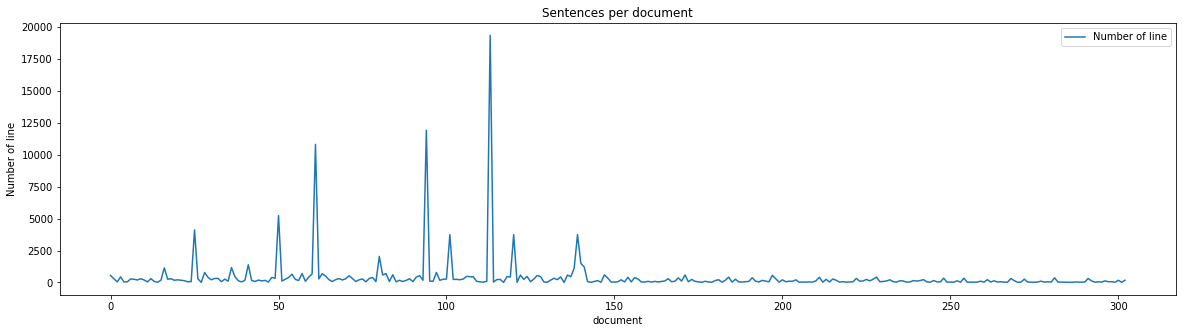

In [2]:
# 2D 그래프로 문서의 문장 계수를 보여줌
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'Number of line': len_list})
df.plot(kind='line', figsize=(20,5))
plt.xlabel('document')
plt.ylabel('Number of line')
plt.title('Sentences per document')
plt.show()

Text(0, 0.5, 'Count')

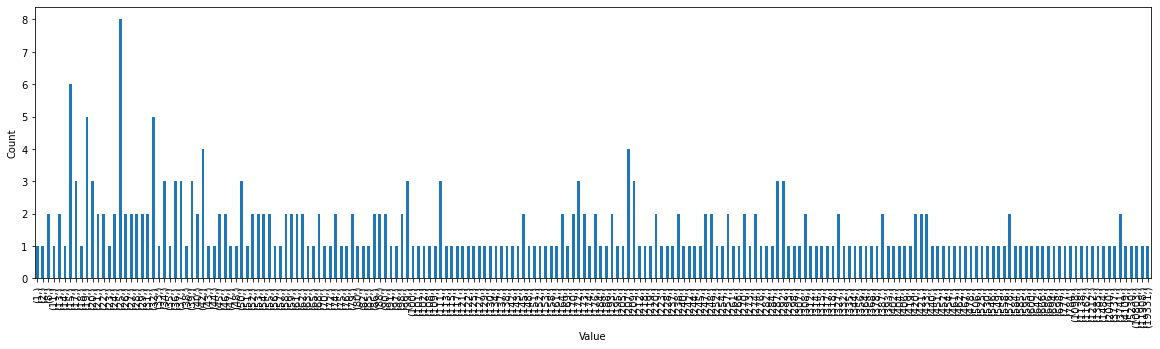

In [3]:
# 임베딩된 문장 계수를 bar 그래프로 보여줌.
import pandas as pd
value_counts = pd.DataFrame(len_list, columns=['values']).value_counts().sort_index()

# kind='bar'
ax = value_counts.plot(kind='bar', x=value_counts.index, y='values', legend=False, figsize=(20,5))
ax.set_xlabel("Value")
ax.set_ylabel("Count")

In [ ]:
#------------------------------------------------------------------------------------------
# 2.유사 문서 파일 만들기
# => 원본 문서 파일과 유사한 파일을 만듬.
# => 문장제거, 문장섞음, 문장대체 등 이용. %로 입력함. 0입력시 해당 방식 pass
# => 문장 대체는 gemma-2b 모델을 이용 함. => 1문서 약 10% 문장 대체할때(대략 30개) 30초 걸림.
#------------------------------------------------------------------------------------------

import os
from utils import create_similar_doc
from similar_doc import MY_similar_doc

settings = myutils.get_options()
remove_per=settings['REMOVE_PER']
shuffle_per=settings['SHUFFLE_PER']
replace_per=settings['REPLACE_PER']
sllm_model_path=settings['sLLM_MODEL']

print(f'*제거문장:{remove_per}%, 섞을문장:{shuffle_per}%, 대체문장: {replace_per}%')
print(f'*대체문장모델:{sllm_model_path}')

mySDoc = MY_similar_doc(model_folder_path=sllm_model_path)

files = df_contexts['file'].values.tolist()
for filePath in tqdm(files):
    srcFilePath = filePath
    tgtFilePath = srcFilePath.replace('/docs/', '/docs-10-20-20/') # docs 폴더를 docs-10-20-20로 만듬
    #print(f'*tgtFilePath:{tgtFilePath}')

    error, msg = mySDoc.create_similar_doc(srcFilePath=srcFilePath, tgtFilePath=tgtFilePath, 
                                           remove_per=remove_per, shuffle_per=shuffle_per, replace_per=replace_per)
    #print(f'*error:{error}')
    #print(f'*msg:{msg}')


In [4]:
#------------------------------------------------------------------------------------------
# 3.임베딩 환경 설정 
# => 임베딩 모델 로딩.
# => 엘라스틱서치:ES 연결
# => 각 인스턴스와 변수들 설정
#------------------------------------------------------------------------------------------
# settings.yaml 설정값 불러옴.
#from transformers import AutoConfig
from utils import MyUtils
myutils = MyUtils(yam_file_path='./data/test_settings.yaml')
settings = myutils.get_options()

# 임베딩 모델 로딩
from es import My_ElasticSearch
from langchain_community.embeddings import (
    HuggingFaceEmbeddings,
    HuggingFaceBgeEmbeddings,
)

embeding_model = "bongsoo/kpf-sbert-128d-v1"
embedding = HuggingFaceEmbeddings(
    model_name=settings["EMBEDDING_MODEL"], 
    show_progress=False
)

# 샘플 텍스트 데이터를 입력하여 모델이 출력 shape(128인지, 768인지) 확인함
sample_text = ["모델의 출력 shape를 확인합니다."]
# 텍스트 데이터를 임베딩 모델에 입력
sample_embedding_vector = embedding.embed_documents(sample_text)
model_shape = len(sample_embedding_vector[0])
print(f'*임베딩 모델: {embedding.model_name}/*shape:{model_shape}')

# elasticsearch 서버 연결
es_url=settings['ES_URL']
es_index_name=settings['ES_INDEX_NAME']
es_index_file_path=settings['ES_INDEX_FILE_PATH']

myes = My_ElasticSearch(es_url=es_url, index_name=es_index_name, index_file_path=es_index_file_path)
print(f'*엘라스틱서치: {myes}')

# global 인스턴스 dict로 정의
global_instance:dict = {'myutils': myutils, 'settings': settings, "embedding": embedding, "myes": myes, "model_shape": model_shape}

embed_type:list = ['*다대다 : 클러스터링 임베딩 검색(mean)', '*일대일 : 평균 임베딩 검색', '*일대다: 평균 임베딩 검색']

print(f'{embed_type[int(settings["SEARCH_EMBED_TYPE"])]}')

*임베딩 모델: bongsoo/kpf-sbert-128d-v1/*shape:128
*[create_index] self.es.indices.delete
*[create_index] self.es.indices.create
*엘라스틱서치: <es.main.My_ElasticSearch object at 0x7fdc8797c820>
*다대다 : 클러스터링 임베딩 검색(mean)


/MOCOMSYS/anaconda3/envs/bong/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


In [5]:
#------------------------------------------------------------------------------------------
# 4.문서 임베딩
# => 원본 문서 폴더를 지정하면 인덱싱 함.
# => **1문서에 평균벡터, 문단벡터 2종류가 인덱싱됨(vector0: 평균벡터, vertor1~9: 문단벡터가 각각 임베딩됨)
#------------------------------------------------------------------------------------------

from docs_func import embedding_folder_doc01

file_folder = "../../data11/docs/"  # 인덱싱할 폴더
del_index = True
content=embedding_folder_doc01(global_instance, file_folder, del_index)
print(f'*인덱싱: {content}')

*[create_index] self.es.indices.delete
*[create_index] self.es.indices.create


 34%|███▍      | 113/329 [00:29<00:47,  4.57it/s]/MOCOMSYS/anaconda3/envs/bong/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
 66%|██████▌   | 216/329 [01:29<00:10, 10.48it/s]/MOCOMSYS/anaconda3/envs/bong/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
 99%|█████████▉| 327/329 [01:40<00:00, 25.40it/s]/MOCOMSYS/anaconda3/envs/bo

*인덱싱: {'error': 0, 'response': '301', 'time': '101.84'}



/MOCOMSYS/anaconda3/envs/bong/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


In [ ]:
#------------------------------------------------------------------------------------------
# 5.검색
# => 비교할 문서는 먼저 '유사 문서 파일 만들기' 이용해서 만듬. 
# => 쿼리문서를 불러와서 방식에 맞게 임베딩한후 ES 쿼리스크립트 만들어서 검색함.
# => 정답과 예측한 결과값을 리스트로 저장해 둠.(* MRR과 검색률 계산을 위해)
#------------------------------------------------------------------------------------------
# 비교할 문서(query 문서)를 불러와서 인덱싱 하고 => ES 검색
from tqdm import tqdm 
from docs_func import search_docs01
from utils import MyUtils
import ast

myutils = MyUtils(yam_file_path='./data/test_settings.yaml')

file_folder = "../../data11/docs-10-20-20/" # 비교할 유사 문서가 있는 폴더
files:list = []
file_paths = myutils.getListOfFiles(file_folder) # 폴더에 파일 path 얻어옴.

for idx, file_path in enumerate(file_paths):
    if '.ipynb_checkpoints' not in file_path:
        files.append(file_path)

print(f'*쿼리문서폴더: {file_folder}')
print(f'*문서수: {len(files)}')
print(f'{embed_type[int(settings["SEARCH_EMBED_TYPE"])]}')

print(f'---------------------------------------------------------------------------')

file_list:list=[]
ground_truths_list:list = []
bi_predictions_list:list = []


for idx, file_path in enumerate(tqdm(files)):
    #if idx >= 5:
    #    break
        
    response = search_docs01(instance=global_instance, file_path=file_path)
    
    # 문자열을 리스트로 변환
    docs = response['response']
    list_data = ast.literal_eval(docs)
    # rfile_name 값들을 추출하여 리스트로 만들기
    rfile_name_list = [item['rfile_name'] for item in list_data]
    
    # 결과 출력
    #print(rfile_name_list)
    
    # 검색결과 파일목록에서 파일명 앞에 '_' 기준으로 번호만 뽑아내고 2차원 predictions_list에 담음
    number_list:list = []
    for rfile_name in rfile_name_list:
        number_str = rfile_name.split("_")[0]
        number = int(number_str)
        number_list.append(number)
        
    bi_predictions_list.append(number_list)
    
    file_name = file_path.split("/")[-1]  
    number_str = file_name.split("_")[0]
    number = int(number_str)
    ground_truths_list.append(number)
    file_list.append(file_name)

  
print(f'*예측치:\n{bi_predictions_list}\n')
print(f'*실제치:\n{ground_truths_list}\n')

In [ ]:
#--------------------------------------------------------------------------------------------------
# 6.MRR 계산
# => 정답 리스트[2,3,1,4] 과 예측검색리스트[[1,2,5,1],[3,4,2,1],[6,5,4,1], [2,3,4,1]]를 입력하여 MRR 스코어 구함
##--------------------------------------------------------------------------------------------------
from utils import mean_reciprocal_rank

bi_ranks, bi_score = mean_reciprocal_rank(ground_truths_list, bi_predictions_list)

# BI-MRR 출력
#myutils.log_message(f'----------------------------------------------------------------------------')
#myutils.log_message('*BI-MRR:{:.4f}'.format(bi_score))
#myutils.log_message(f'*Ranks({len(bi_ranks)}):{bi_ranks[0:10]}')

print(f'---------------------------------------------------------------------------')
print(f'{embed_type[int(settings["SEARCH_EMBED_TYPE"])]}')
print(f'----------------------------------------------------------------------------')
print('*BI-MRR:{:.4f}'.format(bi_score))
print(f'*Ranks({len(bi_ranks)}):{bi_ranks[0:10]}')

# 검색 한 계슈
#logger.info(f'---------------------------------------------------------------------------')
search_count = 0
nosearch_count = 0
nosearch_list = []
for i,item in enumerate(bi_ranks):
    if item != 0:
        search_count += 1
    else:
        nosearch_count += 1
        nosearch_list.append(i)
    
print(f'---------------------------------------------------------------------------')
es_index_name=settings['ES_INDEX_NAME']
print('*검색률: {}/{}({:.2f}%)'.format(search_count, len(bi_ranks), (search_count/len(bi_ranks))*100))
print(f'---------------------------------------------------------------------------')
print('*검색실패 : {}'.format(nosearch_count))
for i, nosearch in enumerate(nosearch_list):
    print(f'*원본명: {file_list[nosearch]}=>*예측:{bi_predictions_list[nosearch]}')